In [4]:
import os
import pandas as pd


In [6]:
os.chdir("../")

In [7]:
!pwd

/Users/m243289/Documents/Drexel/Drexel2023/DSCI631/gamer-anxiety


In [139]:
filepath = "data/cleaned_gamer_data.csv"
nas = ["", " ", "NA", "N/A", "na", "n/a"]
df = pd.read_csv(filepath, na_values=nas, encoding="ISO-8859-1")

In [140]:
df.shape

(13407, 33)


# Potential Modeling Directions

- We plan to use the binary Social Anxiety variable as our target variable with the aim to develop a classifier that can
 predict whether a person has social anxiety or not.

- We could also use the Social Phobia variable as our target variable with the aim to develop a classifier that can
predict the level of social anxiety a person has. This would be a multi-class classification problem and based on the
distribution, we may experience the class imbalance problem.

- Similarly, we could use the binary Anxiety variable as our target variable with the aim to develop a classifier
that can predict whether a person has anxiety or not. We could create a new combined target variable that is a
combination of the Social Anxiety and Anxiety variables. For example, if a person has social anxiety or anxiety
(binary). Such classifier could be used to predict if a person is likely to have a Moderate/Severe SPIN/GAD.

- From the first glance, potential features that could predict whether a person has moderate/severe SPIN/GAD are work,
earnings, life satisfaction. We will explore these features further to see if they are good predictors.


## Classification Models

### Baseline Model

- We will use the logistic regression model as our baseline model, keeping in mind to start with the simplest model
and set of features.

### Decision Tree/Random Forest

- We will use the decision tree and random forest models to see if we can improve the performance of the baseline
model. Decision trees can capture non-linear relationships in the data, and random forests can reduce
potential overfitting and improve generalization.

### Naive Bayes or SVM

- For our third model, we will use either the Naive Bayes or SVM model to compare the performance to predict whether
gamers are likely to have severe social anxiety or not

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import pprint as pp

In [142]:
df.columns

Index(['Game', 'Platform', 'Hours', 'earnings', 'whyplay', 'League', 'streams',
       'Narcissism', 'Gender', 'Age', 'Work', 'Degree', 'Birthplace',
       'Residence', 'Reference', 'Playstyle', 'accept', 'GAD_T', 'SWL_T',
       'SPIN_T', 'Residence_ISO3', 'Birthplace_ISO3', 'social_phobia',
       'social_anxiety', 'anxiety', 'anxiety_binary', 'life_satisfaction',
       'combined_target', 'degree_bin', 'work_bin', 'residence_bin',
       'playstyle_cat', 'earnings_bin'],
      dtype='object')

In [143]:
df["work_bin"].value_counts()
# if "Unemployed / between jobs" then "Unemployed"
df["work_bin"] = df["work_bin"].replace("Unemployed / between jobs", "Unemployed")

In [144]:
targets_bin = df[['social_anxiety', 'social_phobia','anxiety_binary', 'combined_target']]
targets_num = df[['GAD_T', 'SWL_T', 'SPIN_T']]

In [145]:
features = df[['work_bin', 'earnings_bin', 'life_satisfaction', 'Age', 'residence_bin', 'playstyle_cat', 'degree_bin',
               'Narcissism']]

# Target: Combined (Social Anxiety or Anxiety)

## Explore

In [146]:
# Identifying categorical columns
categorical_columns = ['work_bin', 'earnings_bin', 'life_satisfaction', 'residence_bin', 'playstyle_cat',
                       'degree_bin']

# Identifying numeric columns
numeric_columns = ['Age', 'Narcissism']

# Creating a transformer for one hot encoding of categorical variables and scaling of numeric variables
column_transformer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(), categorical_columns),
    ('num', StandardScaler(), numeric_columns)
], remainder='passthrough')


# Applying the transformation to the features
features_encoded = column_transformer.fit_transform(features)



In [147]:
target = targets_bin['combined_target']
X_train, X_temp, y_train, y_temp = train_test_split(features_encoded,target, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# print each
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("========================================")
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (9384, 26) y_train: (9384,)
X_val: (2011, 26) y_val: (2011,)
X_test: (2012, 26) y_test: (2012,)


## Logistic Regression
#### Baseline Model
So we're going to start with Logistic Regression as a baseline like previously discussed

In [148]:
model = LogisticRegression(max_iter=1000)  # Increasing max_iter for convergence
log_reg = Pipeline(steps=[('model', model)])

In [149]:
# training the logistic regression model
log_reg.fit(X_train, y_train)

accuracy = log_reg.score(X_val, y_val)
print("Accuracy:", accuracy)

Accuracy: 0.6290402784684237


In [150]:
# Predicting on the validation set
pred_y = log_reg.predict(X_val)
# Evaluating the model
classification_report_res = classification_report(y_val, pred_y)
print(classification_report_res)
confusion_matrix_res = confusion_matrix(y_val, pred_y)
print(confusion_matrix_res)

              precision    recall  f1-score   support

           0       0.63      0.67      0.65      1022
           1       0.63      0.59      0.61       989

    accuracy                           0.63      2011
   macro avg       0.63      0.63      0.63      2011
weighted avg       0.63      0.63      0.63      2011

[[682 340]
 [406 583]]


### LogReg Analysis

Not ideal.



## Random Forest

In [151]:
model = RandomForestClassifier(random_state=42)
rf = Pipeline(steps=[('model', model)])
# Fit the pipeline on the training data
rf.fit(X_train, y_train)
# Score the model on the test data
accuracy = rf.score(X_val, y_val)
print("Accuracy:", accuracy)

Accuracy: 0.5847836897066137


In [152]:
# Predicting on the test set
pred_y = rf.predict(X_val)
# Evaluating the model
classification_report_res = classification_report(y_val, pred_y)
print(classification_report_res)
confusion_matrix_res = confusion_matrix(y_val, pred_y)
print(confusion_matrix_res)

              precision    recall  f1-score   support

           0       0.59      0.61      0.60      1022
           1       0.58      0.56      0.57       989

    accuracy                           0.58      2011
   macro avg       0.58      0.58      0.58      2011
weighted avg       0.58      0.58      0.58      2011

[[626 396]
 [439 550]]


#### Random Forest Analysis

It should perform better. However, the simple logistic regreesion did better so far.

## Support Vector Machine

In [153]:
# Create a ColumnTransformer for preprocessing
"""column_transformer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(), categorical_columns)
], remainder='passthrough', sparse_threshold=0.0)"""

# Define your model
model = SVC(probability=True, random_state=42)

# Create a pipeline
pipeline = Pipeline(steps=[('model', model)])

pipeline.fit(X_train, y_train)

accuracy = pipeline.score(X_val, y_val)
print("Accuracy:", accuracy)



Accuracy: 0.6280457483838886


In [156]:
# Predicting on the test set
pred_y = pipeline.predict(X_val)
# Evaluating the model
classification_report_res = classification_report(y_val, pred_y)
print(classification_report_res)
confusion_matrix_res = confusion_matrix(y_val, pred_y)
print(confusion_matrix_res)

              precision    recall  f1-score   support

           0       0.63      0.66      0.64      1022
           1       0.63      0.59      0.61       989

    accuracy                           0.63      2011
   macro avg       0.63      0.63      0.63      2011
weighted avg       0.63      0.63      0.63      2011

[[676 346]
 [402 587]]


#### SVM Analysis

Not great. Better than random forest however.

# Next steps

Figure out what features work best here.

Use RFE to pare down features used

In [159]:
# combine features and target
df_revisit = pd.concat([features, targets_bin["combined_target"]], axis=1)
df_revisit

,work_bin,earnings_bin,life_satisfaction,Age,residence_bin,playstyle_cat,degree_bin,Narcissism,combined_target
0,Unemployed,I only play for fun,Slightly Satisfied,25,USA,Singleplayer,College,1.0,0
1,Unemployed,I only play for fun,Slightly Dissatisfied,41,USA,Multi-online-with strangers,College,1.0,1
2,Employed,I only play for fun,Slightly Dissatisfied,32,Germany,Singleplayer,College,4.0,1
3,Employed,I only play for fun,Slightly Dissatisfied,28,USA,Multi-online-with online teammates,College,2.0,0
4,Employed,I only play for fun,Dissatisfied,19,Other,Multi-online-with strangers,High school,1.0,1
...,...,...,...,...,...,...,...,...,...
13402,Student,I only play for fun,Satisfied,22,Other,Multi-online-with strangers,College,3.0,0
13403,Student,I only play for fun,Slightly Satisfied,20,USA,Multi-online-with strangers,High school,2.0,1
13404,Student,I only play for fun,Extremely Satisfied,19,Other,Multi-online-with real life friends,High school,2.0,0
13405,Student,I only play for fun,Slightly Dissatisfied,18,Canada,Singleplayer,High school,2.0,1


In [160]:
df_revisit["combined_target"].value_counts()

combined_target
0    6815
1    6592
Name: count, dtype: int64

In [161]:
df_revisit.columns

Index(['work_bin', 'earnings_bin', 'life_satisfaction', 'Age', 'residence_bin',
       'playstyle_cat', 'degree_bin', 'Narcissism', 'combined_target'],
      dtype='object')

In [162]:
# take care of non-representative categories (<5%)
df_cutdown = df_revisit.copy()

In [163]:
threshold_percentage = 5
threshold_count = len(df_cutdown) * (threshold_percentage / 100)

# Count the occurrences in column 'A'
value_counts = df_cutdown['earnings_bin'].value_counts()
# Find values that occur less frequently than the threshold
values_to_drop = value_counts[value_counts < threshold_count].index
# Drop rows with these values
df_cutdown = df_cutdown[~df_cutdown['earnings_bin'].isin(values_to_drop)]

# Count the occurrences in column 'A'
value_counts = df_cutdown['playstyle_cat'].value_counts()
# Find values that occur less frequently than the threshold
values_to_drop = value_counts[value_counts < threshold_count].index
# Drop rows with these values
df_cutdown = df_cutdown[~df_cutdown['playstyle_cat'].isin(values_to_drop)]

# Count the occurrences in column 'A'
value_counts = df_cutdown['work_bin'].value_counts()
# Find values that occur less frequently than the threshold
values_to_drop = value_counts[value_counts < threshold_count].index
# Drop rows with these values
df_cutdown = df_cutdown[~df_cutdown['work_bin'].isin(values_to_drop)]

In [164]:
df_cutdown.shape

(13058, 9)

In [165]:
df_cutdown

,work_bin,earnings_bin,life_satisfaction,Age,residence_bin,playstyle_cat,degree_bin,Narcissism,combined_target
0,Unemployed,I only play for fun,Slightly Satisfied,25,USA,Singleplayer,College,1.0,0
1,Unemployed,I only play for fun,Slightly Dissatisfied,41,USA,Multi-online-with strangers,College,1.0,1
2,Employed,I only play for fun,Slightly Dissatisfied,32,Germany,Singleplayer,College,4.0,1
3,Employed,I only play for fun,Slightly Dissatisfied,28,USA,Multi-online-with online teammates,College,2.0,0
4,Employed,I only play for fun,Dissatisfied,19,Other,Multi-online-with strangers,High school,1.0,1
...,...,...,...,...,...,...,...,...,...
13402,Student,I only play for fun,Satisfied,22,Other,Multi-online-with strangers,College,3.0,0
13403,Student,I only play for fun,Slightly Satisfied,20,USA,Multi-online-with strangers,High school,2.0,1
13404,Student,I only play for fun,Extremely Satisfied,19,Other,Multi-online-with real life friends,High school,2.0,0
13405,Student,I only play for fun,Slightly Dissatisfied,18,Canada,Singleplayer,High school,2.0,1


#### Usability Assesment
##### Categorical Variables
| Column Name      |Usability|Modify?  |
|------------------|---------|---------|
| GADE             |  YES    | Encode  |
| Game             |  YES    | Encode  |
| Platform         |  YES    | Encode  |
| Earnings         |  YES    | Trim all less than 10, Encode |
| Whyplay          |  YES    | Trim all less than 25, Encode |
| League           |  Maybe  | Requires a lot of precise cleaning, skip?  |
| Gender           |  YES    | Encode  |
| Work             |  YES    | Encode  |
| Degree           |  YES    | Encode  |
| Birthplace       |  Maybe  | 126 Countries represented|
| Residence        |  Maybe  | Similar, could do less than 100 is stripped  |
| Reference        |  NO     |         |
| Playstyle        |  YES    | Trim less than 48, Encode |
| Accept           |  NO     |         |
| Residence_ISO3   | Maybe        |  Better than Residence       |
| Birthplace_ISO3  | Maybe        |  Better than Birthplace       |
| Social_phobia    |  NO, bleed       |         |
| Anxiety          |  NO, bleed       |         |
| Life_satisfaction|   YES      |    Encode    |

##### Numeric Variables
| Column Name      |Usability|Modify?  |
|------------------|---------|---------|
| Hours            | YES     |Trim top 1%, zscore       |
| Streams          | YES     |Trim top 1%, zscore       |
| Narcissism       | YES     |Trim anything above 11, thats the top of the scale, zscore?         |
| Age              | YES     |  zscore?       |
| GAD_T            | NO, bleed        |         |
| SWL_T            |  YES    | NO        |
| SPIN_T           | NO, bleed        |         |
| Social_anxiety   |  NO, bleed       |         |
| Anxiety_binary   |  NO, bleed       |         |
| Combined_target  |  NO, bleed       |         |

# Categorical and Numeric Transformations

In [167]:
target = df_cutdown['combined_target']
features = df_cutdown[['work_bin', 'earnings_bin', 'life_satisfaction', 'Age', 'residence_bin', 'playstyle_cat', 'degree_bin','Narcissism']]

categorical_columns = ['work_bin', 'earnings_bin', 'life_satisfaction', 'residence_bin', 'playstyle_cat',
                       'degree_bin']
numeric_columns = ['Age', 'Narcissism']

column_transformer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(), categorical_columns),
    ('num', StandardScaler(), numeric_columns)
], remainder='passthrough')

# Applying the transformation to the features
features_encoded = column_transformer.fit_transform(features)

In [168]:

X_train, X_temp, y_train, y_temp = train_test_split(features_encoded,target, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# print each
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("========================================")
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (9140, 25) y_train: (9140,)
X_val: (1959, 25) y_val: (1959,)
X_test: (1959, 25) y_test: (1959,)


In [169]:
print(df.shape[0])
print(features_encoded.shape[0])
print(f"Loss of {df.shape[0] - features_encoded.shape[0]} rows")
print(f"Keeping {round((features_encoded.shape[0] / df.shape[0]) * 100, 2)}% of the original dataset")

13407
13058
Loss of 349 rows
Keeping 97.4% of the original dataset


# Feature Selection via SelectKBest

In [177]:
from sklearn.feature_selection import SelectKBest, f_classif
# Simplifying the model: searching for 10 features that contribute the most to the target variable (out of 25
# features after One-Hot Encoding)
selector = SelectKBest(f_classif, k=10)
selector.fit(X_train, y_train)


SelectKBest()

In [180]:
selected_features = selector.get_support(indices=True)
feature_names_transformed = column_transformer.get_feature_names_out()
selected_feature_names = feature_names_transformed[selected_features]
print(selected_feature_names)

['cat__work_bin_Employed' 'cat__work_bin_Unemployed'
 'cat__life_satisfaction_Dissatisfied'
 'cat__life_satisfaction_Extremely Dissatisfied'
 'cat__life_satisfaction_Extremely Satisfied'
 'cat__life_satisfaction_Satisfied'
 'cat__life_satisfaction_Slightly Satisfied' 'cat__degree_bin_College'
 'cat__degree_bin_High school' 'num__Age']


In [183]:
# slice the arrays for the selected features for X_train, X_valid, and X_test
X_train = X_train[:, selected_features]
X_val = X_val[:, selected_features]
X_test = X_test[:, selected_features]


In [184]:
# print shapes
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("========================================")
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (9140, 10) y_train: (9140,)
X_val: (1959, 10) y_val: (1959,)
X_test: (1959, 10) y_test: (1959,)


In [285]:
X_train_df = pd.DataFrame(X_train[:, 0])
X_train_df["source"] = "Training Set"
X_train_df["target"] = y_train.values

X_val_df = pd.DataFrame(X_val[:,0])
X_val_df["source"] = "Validation Set"
X_val_df["target"] = y_val.values

X_test_df = pd.DataFrame(X_test[:,0])
X_test_df["source"] = "Test Set"
X_test_df["target"] = y_test.values

df_plot = pd.concat([X_train_df, X_val_df, X_test_df], axis=0)





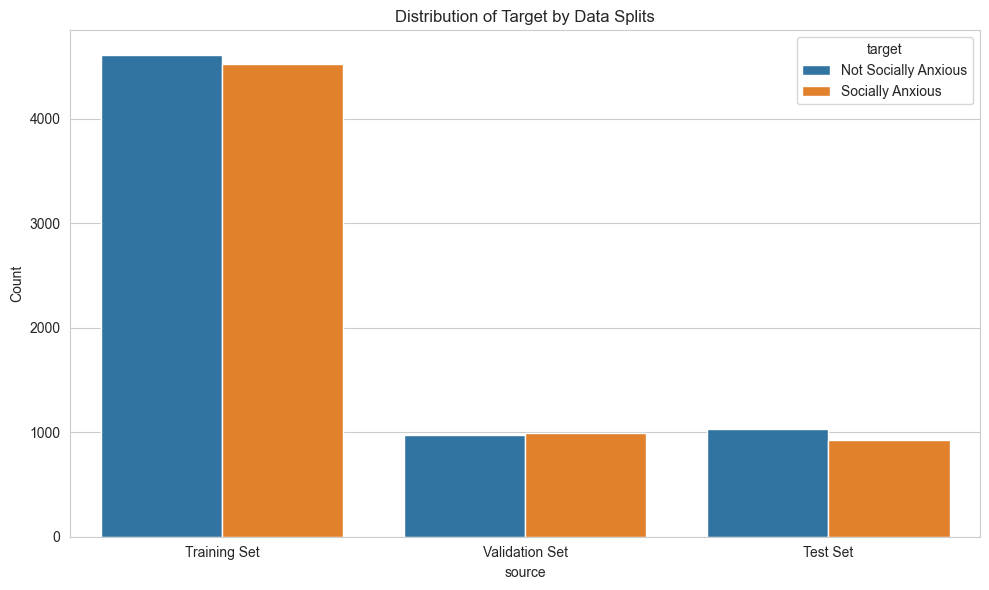

In [292]:
# barplot to count source by target
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.countplot(x="source", hue="target", data=df_plot)
labels = ['Not Socially Anxious', 'Socially Anxious']
for t, l in zip(ax.legend_.texts, labels): t.set_text(l)
ax.set_ylabel('Count')
ax.set_title('Distribution of Target by Data Splits')
ax.xaxis.grid(False)

plt.tight_layout()
plt.savefig("docs/TargetBySource.png")
plt.show()

# Hyperparameter Tuning

## Logistic Regression


In [185]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Assuming the data is already preprocessed and split into train, test, and validation sets

# Defining the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithms to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

# Initializing the Logistic Regression model
logistic_regression = LogisticRegression()

# Setting up GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(estimator=logistic_regression, param_grid=param_grid_lr, cv=5, verbose=1, scoring='accuracy')

# Placeholder for running the grid search
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/Users/m243289/virtualenvs/mldl/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/m243289/virtualenvs/mldl/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/m243289/virtualenvs/mldl/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/m243289/virtualenvs/mldl/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/m243289/virtualenvs/mldl/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/m243289/virtu

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy', verbose=1)

In [186]:
grid_search_lr.best_params_

{'C': 0.01, 'max_iter': 100, 'solver': 'newton-cg'}

In [187]:
grid_search_lr.best_score_

0.6319474835886215

In [189]:
# Predicting on the test set
log_best_model = grid_search_lr.best_estimator_
pred_y = log_best_model.predict(X_val)

# Evaluating the model
classification_report_res = classification_report(y_val, pred_y)
print(classification_report_res)
confusion_matrix_res = confusion_matrix(y_val, pred_y)
print(confusion_matrix_res)

              precision    recall  f1-score   support

           0       0.63      0.66      0.64       970
           1       0.65      0.63      0.64       989

    accuracy                           0.64      1959
   macro avg       0.64      0.64      0.64      1959
weighted avg       0.64      0.64      0.64      1959

[[637 333]
 [370 619]]


### Logistic Regression Analysis

In [224]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score


def get_model_results(model, model_name):
    tuned_params = model.best_params_

    best_score = model.best_score_
    auc_score = roc_auc_score(y_val, pred_y)
    accuracy = accuracy_score(y_val, pred_y)
    precision = precision_score(y_val, pred_y)
    recall = recall_score(y_val, pred_y)

    df_results = pd.DataFrame(
        {'Model': model_name, 'Best Params': [tuned_params], 'AUC': auc_score,
         'Accuracy': accuracy, 'Precision': precision, 'Recall': recall})

    df_results["AUC"] = df_results["AUC"].map('{:,.3f}'.format)
    df_results['Accuracy'] = df_results['Accuracy'].map('{:,.2%}'.format)
    df_results['Precision'] = df_results['Precision'].map('{:,.2%}'.format)
    df_results['Recall'] = df_results['Recall'].map('{:,.2%}'.format)
    return df_results

# create a df to host best params and Validation Set results
df_results = get_model_results(grid_search_lr, "LogisticRegression")
df_results

,Model,Best Params,AUC,Accuracy,Precision,Recall
0,LogisticRegression,"{'C': 0.01, 'max_iter': 100, 'solver': 'newton...",0.641,64.11%,65.02%,62.59%


### Feature Importance


<Figure size 640x480 with 0 Axes>

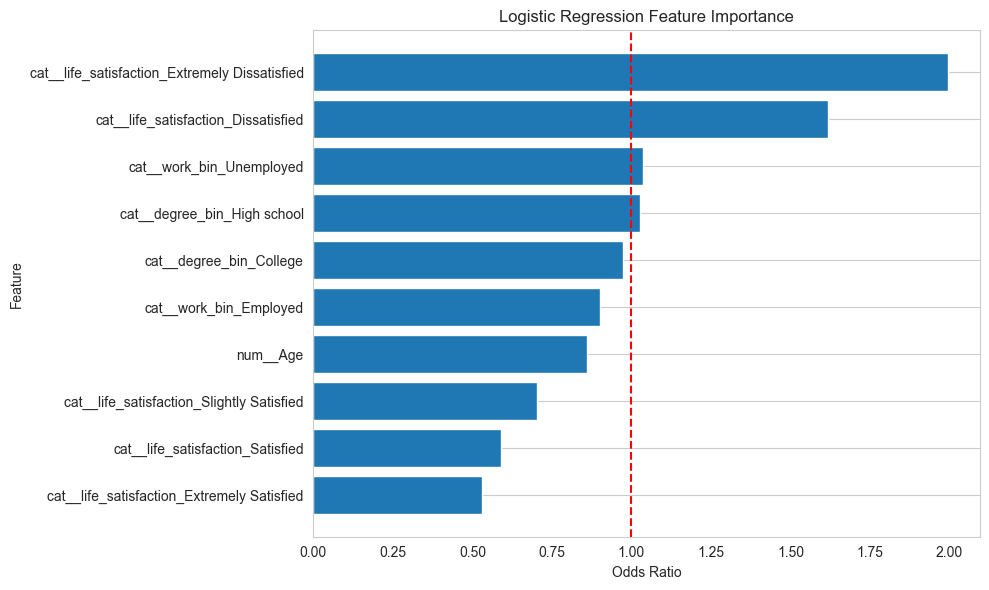

In [297]:
import matplotlib.pyplot as plt
import numpy as np
weights = log_best_model.coef_[0]
feature_names = selected_feature_names

odds_ratios = np.exp(weights)
sorted_indices = np.argsort(np.abs(odds_ratios))
# sorted_indices = np.argsort((weights))[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_odds = odds_ratios[sorted_indices]

plt.clf()
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.barh(np.arange(len(sorted_feature_names)), sorted_odds, tick_label=sorted_feature_names)
# add vertical line at xaxis 1.0
ax.axvline(x=1.0, color='red', linestyle='--')
ax.set_xlabel('Odds Ratio')
ax.set_ylabel('Feature')
ax.set_title('Logistic Regression Feature Importance')
ax.xaxis.grid(False)

plt.tight_layout()
# plt.show()

plt.savefig("docs/BestLogReg_FeatureImportance.png")

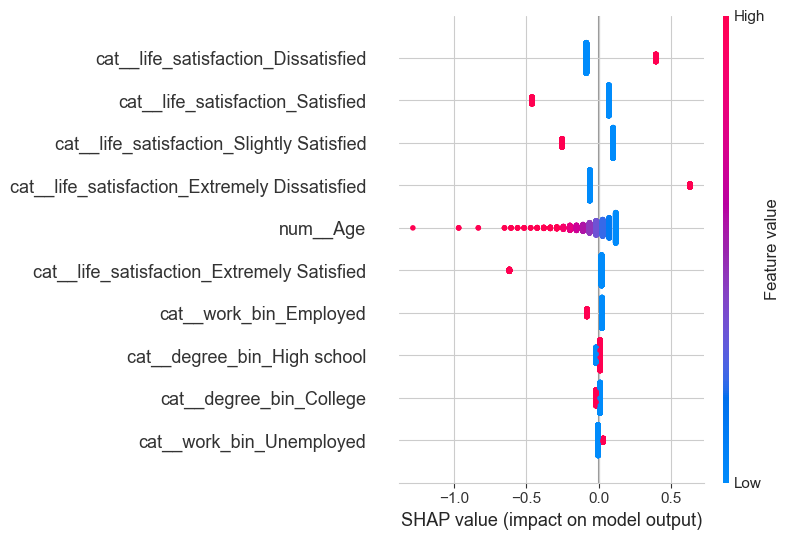

<Figure size 640x480 with 0 Axes>

In [248]:
import shap

expaliner_lr = shap.LinearExplainer(log_best_model, X_train)
shap_values_lr = expaliner_lr.shap_values(X_val)

shap.summary_plot(shap_values_lr, X_val, feature_names=feature_names)
plt.savefig("docs/BestLogReg_SHAP.png")

## Random Forest


In [231]:
from sklearn.ensemble import RandomForestClassifier

# Defining the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
    'bootstrap': [False, False]  # Whether bootstrap samples are used when building trees
}

# Initializing the Random Forest model
random_forest = RandomForestClassifier()

# Setting up GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid_rf, cv=5, verbose=2, scoring='accuracy')

grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; tota

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [False, False],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring='accuracy', verbose=2)

In [232]:
grid_search_rf.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 10}

In [233]:
grid_search_rf.best_score_

0.6206783369803064

In [234]:
# Predicting on the test set
rf_best_model = grid_search_rf.best_estimator_
pred_y = rf_best_model.predict(X_val)
# Evaluating the model
classification_report_res = classification_report(y_val, pred_y)
print(classification_report_res)
confusion_matrix_res = confusion_matrix(y_val, pred_y)
print(confusion_matrix_res)

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       970
           1       0.65      0.63      0.64       989

    accuracy                           0.64      1959
   macro avg       0.64      0.64      0.64      1959
weighted avg       0.64      0.64      0.64      1959

[[631 339]
 [369 620]]


### Random Forest Analysis

In [236]:
# create a df to host best params and Validation Set results

df_results2 = get_model_results(grid_search_rf, "RandomForest")

df_results = pd.concat([df_results, df_results2], axis=0)
df_results


,Model,Best Params,AUC,Accuracy,Precision,Recall
0,LogisticRegression,"{'C': 0.01, 'max_iter': 100, 'solver': 'newton...",0.641,64.11%,65.02%,62.59%
0,RandomForest,"{'bootstrap': False, 'max_depth': 10, 'min_sam...",0.639,63.86%,64.65%,62.69%


### Feature Importance

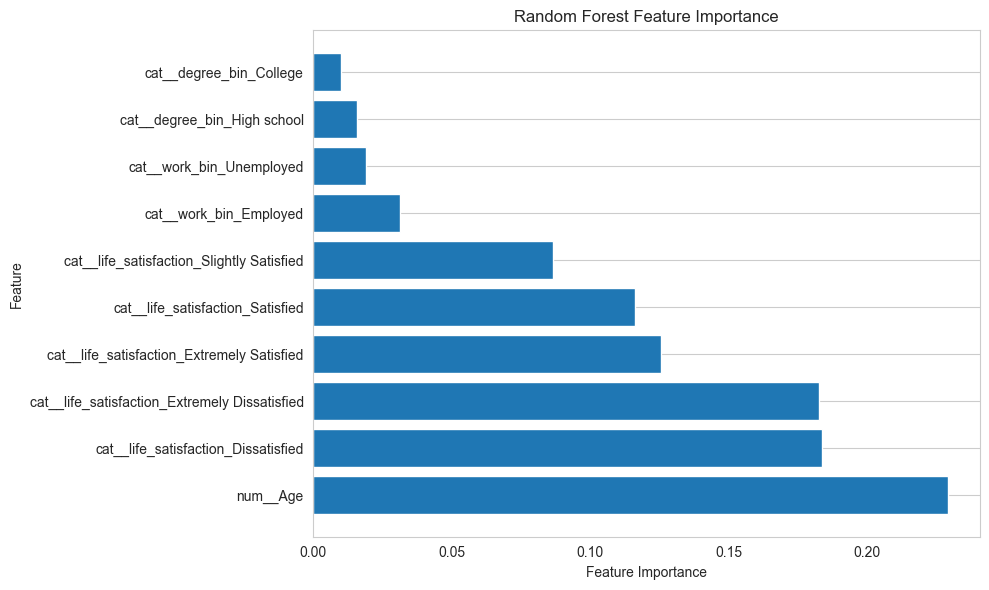

In [249]:
weights = rf_best_model.feature_importances_
feature_names = selected_feature_names

sorted_indices = np.argsort(weights)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_weights = weights[sorted_indices]

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.barh(np.arange(len(sorted_feature_names)), sorted_weights, tick_label=sorted_feature_names)
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
ax.set_title('Random Forest Feature Importance')

# Remove horizontal grid lines
ax.xaxis.grid(False)

plt.tight_layout()
plt.savefig("docs/BestRF_FeatureImportance.png")



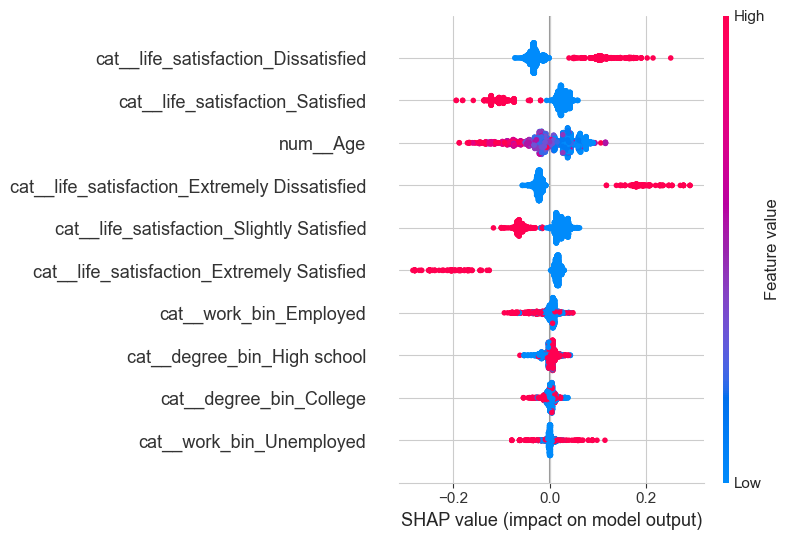

<Figure size 640x480 with 0 Axes>

In [241]:
expaliner_rf = shap.TreeExplainer(rf_best_model)
shap_values_rf = expaliner_rf.shap_values(X_val)
shap.summary_plot(shap_values_rf[1], X_val, feature_names=feature_names)

plt.savefig("docs/BestRF_SHAP.png")


In [250]:
from sklearn.svm import SVC

# Defining the parameter grid for SVM (Support Vector Machine)
param_grid_svm = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['rbf', 'sigmoid']  # Specifies the kernel type to be used in the algorithm
}

# Initializing the SVM model
svm_model = SVC()

# Setting up GridSearchCV for SVM
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=5, verbose=2, scoring='accuracy')

grid_search_svm.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   2.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   2.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   2.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   2.2s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   2.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   3.8s
[CV] END .......................C=0.1, gamma=0.

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [251]:
grid_search_svm.best_params_

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

In [252]:
grid_search_svm.best_score_

0.6329321663019695

In [253]:
# Predicting on the test set
svm_best_model = grid_search_svm.best_estimator_
pred_y = svm_best_model.predict(X_val)
# Evaluating the model
classification_report_res = classification_report(y_val, pred_y)
print(classification_report_res)
confusion_matrix_res = confusion_matrix(y_val, pred_y)
print(confusion_matrix_res)

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       970
           1       0.65      0.62      0.63       989

    accuracy                           0.64      1959
   macro avg       0.64      0.64      0.64      1959
weighted avg       0.64      0.64      0.64      1959

[[647 323]
 [379 610]]


### SVM Analysis

In [255]:
# create a df to host best params and Validation Set results

df_results3 = get_model_results(grid_search_svm, "SVM")

df_results = pd.concat([df_results, df_results3], axis=0)

df_results

,Model,Best Params,AUC,Accuracy,Precision,Recall
0,LogisticRegression,"{'C': 0.01, 'max_iter': 100, 'solver': 'newton...",0.641,64.11%,65.02%,62.59%
0,RandomForest,"{'bootstrap': False, 'max_depth': 10, 'min_sam...",0.639,63.86%,64.65%,62.69%
0,SVM,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.642,64.17%,65.38%,61.68%


In [260]:
df_results.to_csv("docs/BestModels_Results.csv")


In [254]:
print(f"Logistic Regression: {grid_search_lr.best_score_}")
print(f"Random Forest:       {grid_search_rf.best_score_}")
print(f"SVM:                 {grid_search_svm.best_score_}")
print("\n")
print(f"Logistic Regression: {grid_search_lr.best_params_}")
print(f"Random Forest:       {grid_search_rf.best_params_}")
print(f"SVM:                 {grid_search_svm.best_params_}")

Logistic Regression: 0.6319474835886215
Random Forest:       0.6206783369803064
SVM:                 0.6329321663019695


Logistic Regression: {'C': 0.01, 'max_iter': 100, 'solver': 'newton-cg'}
Random Forest:       {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 10}
SVM:                 {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


# Final Model Selection - Logistic Regression

After conducting grid searches, the performance of the Logistic Regression model closely matches that of the SVM with an RBF kernel. However, the Logistic Regression model offers superior interpretability due to its direct access to coefficients. Notably, the Logistic Regression model exhibits a slightly higher recall rate, which is particularly important in our use case. This advantage is underscored by the fact that missing a person with social anxiety carries a higher cost than misclassifying someone as having social anxiety

## Evaluation on the Test Set (Hold-out Set)


In [262]:
# Predicting on the test set
pred_y = log_best_model.predict(X_test)
# Evaluating the model
classification_report_res = classification_report(y_test, pred_y)
print(classification_report_res)


              precision    recall  f1-score   support

           0       0.66      0.68      0.67      1035
           1       0.63      0.61      0.62       924

    accuracy                           0.65      1959
   macro avg       0.65      0.64      0.64      1959
weighted avg       0.65      0.65      0.65      1959



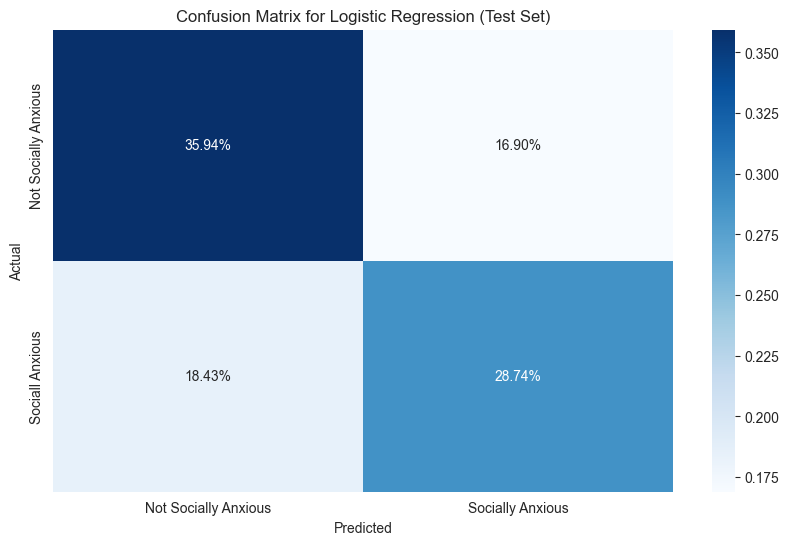

In [267]:
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_y, normalize="all")
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Not Socially Anxious', 'Socially Anxious'],
            yticklabels=['Not Socially Anxious', 'Sociall Anxious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression (Test Set)')
plt.savefig("docs/BestLogReg_ConfusionMatrix.png")

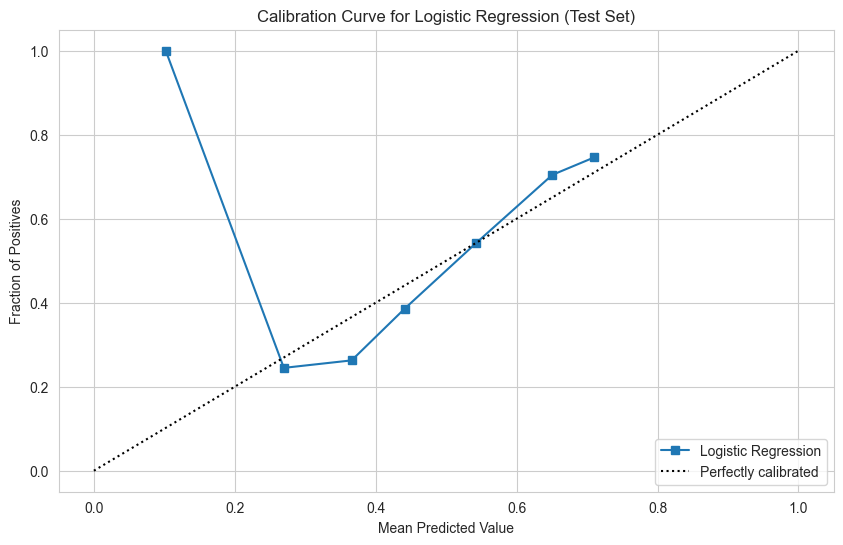

In [270]:
from sklearn.calibration import calibration_curve

prob_pos = log_best_model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Logistic Regression")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean Predicted Value")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.title('Calibration Curve for Logistic Regression (Test Set)')
plt.savefig("docs/BestLogReg_CalibrationCurve.png")
plt.show()

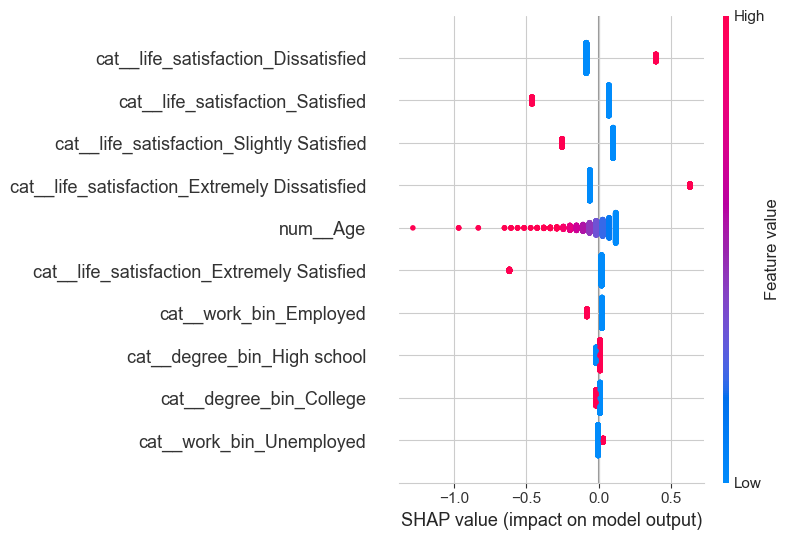

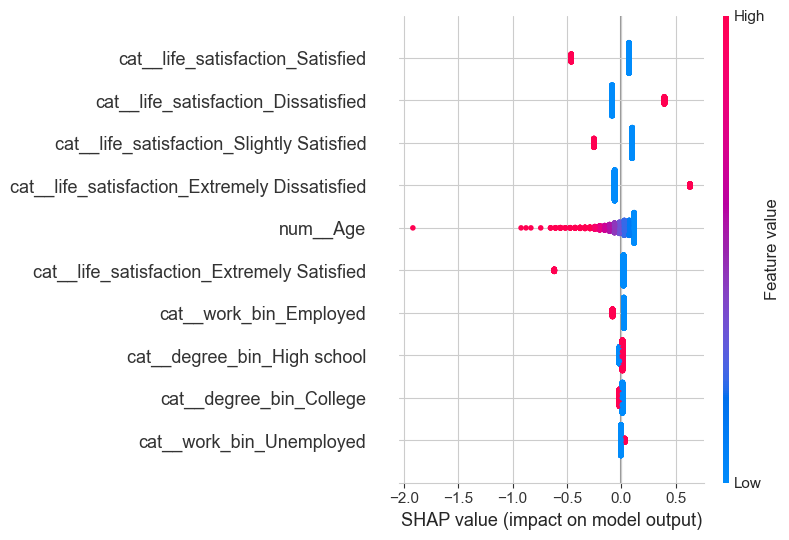

<Figure size 640x480 with 0 Axes>

In [271]:
# plot shap importance
explainer_lr = shap.LinearExplainer(log_best_model, X_train)

shap_values_lr_val = explainer_lr.shap_values(X_val)

shap.summary_plot(shap_values_lr_val, X_val, feature_names=feature_names)
plt.savefig("docs/BestLogReg_SHAP_val.png")

shap_values_lr_test = explainer_lr.shap_values(X_test)

shap.summary_plot(shap_values_lr_test, X_test, feature_names=feature_names)
plt.savefig("docs/BestLogReg_SHAP_test.png")

In [273]:
# compute auc, accuracy, precision, recall for the test set
auc_score = roc_auc_score(y_test, pred_y)
accuracy = accuracy_score(y_test, pred_y)
precision = precision_score(y_test, pred_y)
recall = recall_score(y_test, pred_y)

df_results_test = pd.DataFrame(
    {'Model': "LogisticRegression", 'Best Params': [grid_search_lr.best_params_], 'AUC': auc_score,
     'Accuracy': accuracy, 'Precision': precision, 'Recall': recall})

df_results_test["AUC"] = df_results_test["AUC"].map('{:,.3f}'.format)
df_results_test['Accuracy'] = df_results_test['Accuracy'].map('{:,.2%}'.format)
df_results_test['Precision'] = df_results_test['Precision'].map('{:,.2%}'.format)
df_results_test['Recall'] = df_results_test['Recall'].map('{:,.2%}'.format)

df_results_test.to_csv("docs/TESTSET_BestLogReg_Results.csv")